In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import norm, t


In [41]:
df = pd.read_csv("/home/hujianjin/projects/LinearRegression_XAUUSD/price_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [42]:
# Feature engineering

# Short-term trend (3-week SMA)
df['SMA_3'] = df['Close'].rolling(window=3).mean()
# Long-term trend (5-week SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
# Percentage change (2 weeks)
df['Pct_Change_2w'] = df['Close'].pct_change(periods=2)
# Volatility (High-Low relative to Open)
df['Volatility'] = (df['High'] - df['Low']) / df['Open']
# Rolling 3-week volatility (std dev of Close)
df['Volatility_3w'] = df['Close'].rolling(window=3).std()
# High to Open ratio
df['High_Open_ratio'] = df['High'] / df['Open']
# Volume change from previous week
df['Volume_Change'] = df['Tick_Vol'] - df['Tick_Vol'].shift(1)
# Volatility normalized by tick volume
df['Volatility_per_Tick'] = df['Volatility'] / df['Tick_Vol']
# Momentum High (1 week)
df['Momentum_1w_High'] = df['High'] - df['High'].shift(1)
# Momentum High (2 weeks)
df['Momentum_2w_High'] = df['High'] - df['High'].shift(2)
# Lagged High price (1 week)
df['High_lag1'] = df['High'].shift(1)
# Intraperiod upward movement relative to Close
df['High_Close_gap_pct'] = (df['High'] - df['Close']) / df['Close']
# Max High over last 3 weeks (potential breakout indicator)
df['Max_High_3w'] = df['High'].rolling(window=3).max()
# Target variable: Next week's High price
df['High_price_next_week'] = df['High'].shift(-1)


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 286 entries, 2020-01-05 to 2025-06-22
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  286 non-null    float64
 1   High                  286 non-null    float64
 2   Low                   286 non-null    float64
 3   Close                 286 non-null    float64
 4   Tick_Vol              286 non-null    int64  
 5   SMA_3                 284 non-null    float64
 6   SMA_5                 282 non-null    float64
 7   Pct_Change_2w         284 non-null    float64
 8   Volatility            286 non-null    float64
 9   Volatility_3w         284 non-null    float64
 10  High_Open_ratio       286 non-null    float64
 11  Volume_Change         285 non-null    float64
 12  Volatility_per_Tick   286 non-null    float64
 13  Momentum_1w_High      285 non-null    float64
 14  Momentum_2w_High      284 non-null    float64
 15  High

In [44]:
df

,Open,High,Low,Close,Tick_Vol,SMA_3,SMA_5,Pct_Change_2w,Volatility,Volatility_3w,High_Open_ratio,Volume_Change,Volatility_per_Tick,Momentum_1w_High,Momentum_2w_High,High_lag1,High_Close_gap_pct,Max_High_3w,High_price_next_week
Date,,,,,,,,,,,,,,,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142,NaN,NaN,NaN,0.045604,NaN,1.033747,NaN,1.093238e-07,NaN,NaN,NaN,0.031510,NaN,1561.44
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879,NaN,NaN,NaN,0.016405,NaN,1.000980,-128263.0,5.678773e-08,-49.81,NaN,1611.25,0.002852,NaN,1575.73
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672,1563.483333,NaN,0.006011,0.018902,7.319032,1.011692,-25207.0,7.168696e-08,14.29,-35.52,1561.44,0.002743,1611.25,1590.29
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721,1572.540000,NaN,0.020681,0.017067,16.129191,1.005787,105049.0,4.628649e-08,14.56,28.85,1575.73,0.000686,1590.29,1591.88
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703,1576.896667,1569.944,-0.000859,0.027935,10.676359,1.000673,-21018.0,8.034286e-08,1.59,16.15,1590.29,0.013891,1591.88,1584.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819,3281.773333,3280.814,0.027234,0.033190,77.538827,1.000477,-125606.0,3.105284e-08,-9.23,65.00,3365.77,0.020740,3365.77,3403.46
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423,3317.996667,3295.504,-0.013705,0.032818,34.473300,1.031902,113604.0,2.775445e-08,46.92,37.69,3356.54,0.028288,3403.46,3446.75
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543,3343.350000,3317.406,0.043651,0.046304,77.418510,1.041147,-22880.0,3.993277e-08,43.29,90.21,3403.46,0.004333,3446.75,3451.21


In [45]:
# Drop unnecessary columns and rows with NaN values
df1 = (
    df.drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
    .dropna()
)

In [46]:
df2 = df[-1:]  # Keep the last row for prediction

In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2020-02-02 to 2025-06-15
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SMA_3                 281 non-null    float64
 1   SMA_5                 281 non-null    float64
 2   Pct_Change_2w         281 non-null    float64
 3   Volatility            281 non-null    float64
 4   Volatility_3w         281 non-null    float64
 5   High_Open_ratio       281 non-null    float64
 6   Volume_Change         281 non-null    float64
 7   Volatility_per_Tick   281 non-null    float64
 8   Momentum_1w_High      281 non-null    float64
 9   Momentum_2w_High      281 non-null    float64
 10  High_lag1             281 non-null    float64
 11  High_Close_gap_pct    281 non-null    float64
 12  Max_High_3w           281 non-null    float64
 13  High_price_next_week  281 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


In [48]:
df1

,SMA_3,SMA_5,Pct_Change_2w,Volatility,Volatility_3w,High_Open_ratio,Volume_Change,Volatility_per_Tick,Momentum_1w_High,Momentum_2w_High,High_lag1,High_Close_gap_pct,Max_High_3w,High_price_next_week
Date,,,,,,,,,,,,,,
2020-02-02,1576.896667,1569.944,-0.000859,0.027935,10.676359,1.000673,-21018.0,8.034286e-08,1.59,16.15,1590.29,0.013891,1591.88,1584.91
2020-02-09,1580.926667,1574.240,-0.003580,0.014686,9.823158,1.008469,-74435.0,5.374091e-08,-6.97,-5.38,1591.88,0.000884,1591.88,1649.12
2020-02-16,1598.883333,1591.454,0.046495,0.044447,38.852343,1.042361,33097.0,1.450794e-07,64.21,57.24,1584.91,0.003682,1649.12,1689.25
2020-02-23,1604.033333,1594.274,0.001269,0.076510,33.821680,1.021775,342761.0,1.178660e-07,40.13,104.34,1649.12,0.065423,1689.25,1691.93
2020-03-01,1633.966667,1611.096,0.018405,0.073311,44.597355,1.063324,-94911.0,1.322787e-07,2.68,42.81,1689.25,0.011128,1691.93,1703.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,3293.116667,3286.262,0.010068,0.050235,81.374118,1.046740,-119125.0,4.205799e-08,74.23,-71.20,3291.54,0.002965,3436.97,3356.54
2025-05-25,3281.773333,3280.814,0.027234,0.033190,77.538827,1.000477,-125606.0,3.105284e-08,-9.23,65.00,3365.77,0.020740,3365.77,3403.46
2025-06-01,3317.996667,3295.504,-0.013705,0.032818,34.473300,1.031902,113604.0,2.775445e-08,46.92,37.69,3356.54,0.028288,3403.46,3446.75


In [49]:
# features selection
features = [
    'SMA_3', 'SMA_5',
    'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'High_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Momentum_1w_High', 'Momentum_2w_High', 'High_lag1',
    'High_Close_gap_pct', 'Max_High_3w'
]

In [50]:
# Select features and target
X = df1[features].values
y = df1['High_price_next_week'].values

In [51]:
# Final Holdout Split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [52]:
# Display information about the datasets
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_shape: {y_test.shape}")

X_train_full shape: (224, 13)
y_train_full shape: (224,)
X_test shape: (57, 13)
y_test_shape: (57,)


In [53]:
# Scale numeric features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Initialize TimeSeriesSplit for model evaluation
# no hyperparameter tuning in this example
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store scores
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Time series cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled)):
    X_train_scaled, X_val_scaled = X_train_full_scaled[train_idx], X_train_full_scaled[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)*100
    r2 = r2_score(y_val, y_val_pred)

    # Store scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold + 1}: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, R² = {r2:.4f}")

# Print average scores
print("\nAverage CV Scores:")
print(f"MAE:  {np.mean(mae_scores):.4f}")
print(f"MSE:  {np.mean(mse_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}")
print(f"R²:   {np.mean(r2_scores):.4f}")


Fold 1: MAE = 28.5338, MSE = 1308.5527, RMSE = 36.1739, MAPE = 1.5566, R² = 0.6373
Fold 2: MAE = 20.3174, MSE = 609.4170, RMSE = 24.6864, MAPE = 1.0858, R² = 0.8755
Fold 3: MAE = 21.6055, MSE = 704.7290, RMSE = 26.5467, MAPE = 1.2033, R² = 0.8971
Fold 4: MAE = 19.1606, MSE = 795.9127, RMSE = 28.2119, MAPE = 0.9714, R² = 0.7659
Fold 5: MAE = 30.6758, MSE = 1600.8040, RMSE = 40.0100, MAPE = 1.4187, R² = 0.9408

Average CV Scores:
MAE:  24.0586
MSE:  1003.8831
RMSE: 31.1258
MAPE: 1.2472
R²:   0.8233


In [55]:
# Fit model on Full Training Set
model.fit(X_train_full_scaled, y_train_full)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [56]:
# Prediction on full training set
y_train_full_pred = model.predict(X_train_full_scaled)

In [57]:
# Prediction on Test Set
y_test_pred = model.predict(X_test_scaled)

In [58]:
results = pd.DataFrame({
    "predicted": y_test_pred,          # model's predicted high prices
    "actual": y_test                   # actual high prices
})
print(results)

      predicted    actual
0   2403.219487  2363.962
1   2354.144722  2387.612
2   2341.795301  2341.555
3   2345.965935  2368.599
4   2353.211518  2339.569
5   2334.950168  2392.840
6   2415.334855  2424.419
7   2444.848447  2483.559
8   2444.843601  2431.895
9   2409.897599  2477.509
10  2487.119481  2458.649
11  2464.646634  2509.640
12  2527.324000  2531.559
13  2547.763075  2528.930
14  2508.358488  2529.129
15  2511.679721  2585.990
16  2607.871775  2625.670
17  2661.849490  2685.510
18  2694.852441  2673.070
19  2664.967866  2661.325
20  2650.398789  2722.419
21  2733.168754  2758.310
22  2770.390707  2790.040
23  2754.298591  2749.779
24  2720.837884  2686.071
25  2633.817911  2716.189
26  2757.362188  2721.067
27  2729.631105  2656.979
28  2645.157115  2725.860
29  2692.887913  2664.260
30  2636.469150  2638.929
31  2610.941939  2665.186
32  2652.824578  2697.825
33  2713.492764  2724.667
34  2727.577582  2785.820
35  2800.642057  2816.879
36  2832.282169  2886.590
37  2903.285

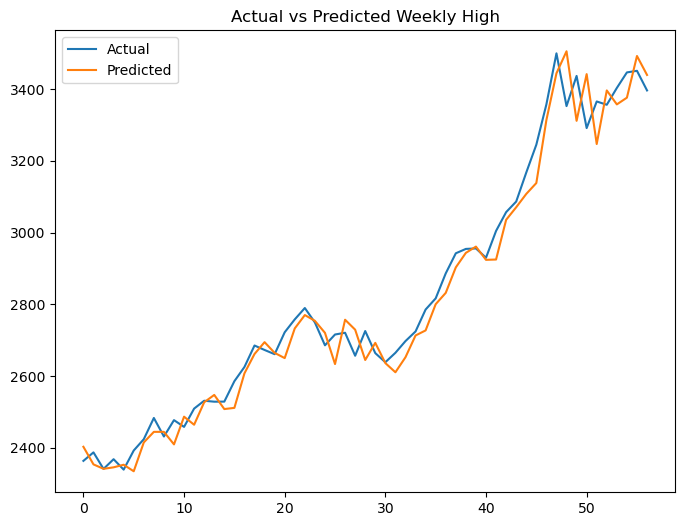

In [59]:
# Plot actual vs predicted line chart on test set
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Actual vs Predicted Weekly High")
plt.legend()
plt.show()

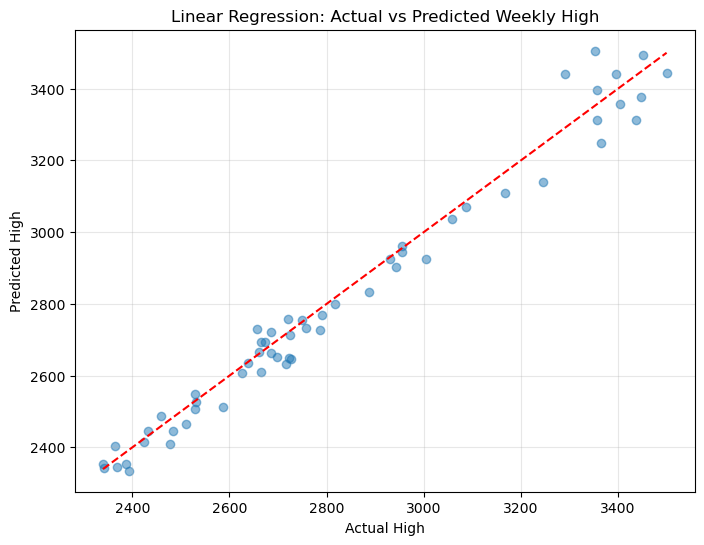

In [60]:
# Plot actual vs predicted scatter plot on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual High')
plt.ylabel('Predicted High')
plt.title('Linear Regression: Actual vs Predicted Weekly High')
plt.grid(True, alpha=0.3)

In [61]:
# Compute performance metrics on test data

model_test_mae = mean_absolute_error(y_test, y_test_pred)
model_test_mse = mean_squared_error(y_test, y_test_pred)
model_test_rmse = np.sqrt(model_test_mse)
model_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)*100
model_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Linear Regression Performance on Test Data:")
print(f"Model - MAE:  {model_test_mae:.3f}")
print(f"        MSE:  {model_test_mse:.3f}")
print(f"        RMSE: {model_test_rmse:.3f}")
print(f"        MAPE: {model_test_mape:.3f}")
print(f"        R²:   {model_test_r2:.3f}")

Linear Regression Performance on Test Data:
Model - MAE:  43.587
        MSE:  3160.269
        RMSE: 56.216
        MAPE: 1.496
        R²:   0.974


In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2025-06-22 to 2025-06-22
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  1 non-null      float64
 1   High                  1 non-null      float64
 2   Low                   1 non-null      float64
 3   Close                 1 non-null      float64
 4   Tick_Vol              1 non-null      int64  
 5   SMA_3                 1 non-null      float64
 6   SMA_5                 1 non-null      float64
 7   Pct_Change_2w         1 non-null      float64
 8   Volatility            1 non-null      float64
 9   Volatility_3w         1 non-null      float64
 10  High_Open_ratio       1 non-null      float64
 11  Volume_Change         1 non-null      float64
 12  Volatility_per_Tick   1 non-null      float64
 13  Momentum_1w_High      1 non-null      float64
 14  Momentum_2w_High      1 non-null      float64
 15  High_l

In [63]:
# last row features selection
features = [
    'SMA_3', 'SMA_5',
    'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'High_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Momentum_1w_High', 'Momentum_2w_High', 'High_lag1',
    'High_Close_gap_pct', 'Max_High_3w'
]
X_last = df2[features]

In [64]:
# Scale the last row features
X_last_scaled = scaler.transform(X_last)
# Predict the next week's close price
predicted_next = model.predict(X_last_scaled)
# Extract scalar value from the prediction
predicted_next = predicted_next[0]
print(f"Predicted XAUUSD Weekly High for the week of <2025-06-29>: {predicted_next:.3f}")


Predicted XAUUSD Weekly High for the week of <2025-06-29>: 3353.418


/home/hujianjin/miniconda3/envs/forecasting_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


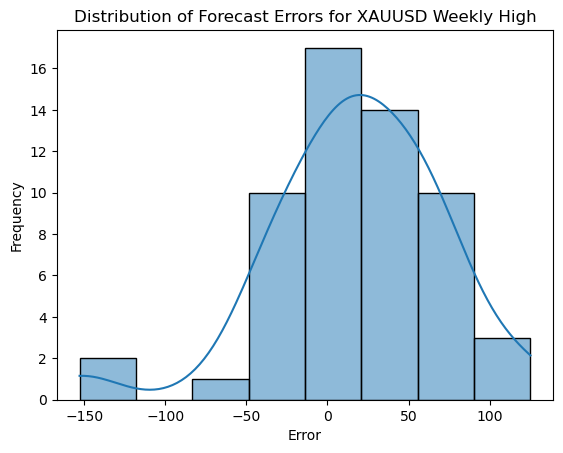

In [65]:
# Histogram + density curve of forecast errors
errors = y_test - y_test_pred  # residuals/errors
sns.histplot(errors, kde=True)
plt.title("Distribution of Forecast Errors for XAUUSD Weekly High")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

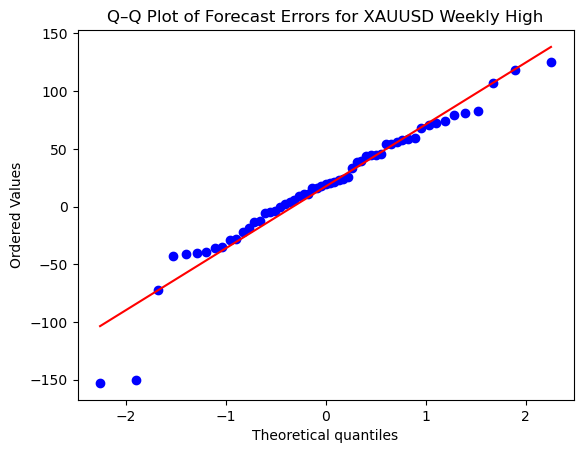

In [66]:
# Q–Q Plot of forecast errors
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q–Q Plot of Forecast Errors for XAUUSD Weekly High")
plt.show()


In [67]:
from scipy.stats import t, norm

def probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=None):
    """
    Calculate RMSE-based and MAPE-based probabilistic ranges for a predicted value.
    Automatically uses t-distribution if sample size (n) is provided and n < 100.
    """
    # Ensure MAPE is in decimal form
    if mape > 1:
        mape = mape / 100.0
    
    # Choose correct distribution for critical value
    if n is not None and n < 100:
        z_or_t = t.ppf(0.5 + confidence / 2, df=n - 1)
        dist_used = "t-distribution"
    else:
        z_or_t = norm.ppf(0.5 + confidence / 2)
        dist_used = "z-distribution"
    
    # --- RMSE-based ---
    rmse_margin = z_or_t * rmse
    rmse_lower = predicted_price - rmse_margin
    rmse_upper = predicted_price + rmse_margin
    
    # --- MAPE-based ---
    sigma_pct = mape / 0.8  # Approx std dev of % errors
    mape_margin_pct = z_or_t * sigma_pct
    mape_lower = predicted_price * (1 - mape_margin_pct)
    mape_upper = predicted_price * (1 + mape_margin_pct)
    
    return {
        "confidence": confidence,
        "critical_value": z_or_t,
        "distribution_used": dist_used,
        "rmse_based": {
            "margin_abs": rmse_margin,
            "lower": rmse_lower,
            "upper": rmse_upper
        },
        "mape_based": {
            "margin_pct": mape_margin_pct * 100,  # in %
            "lower": mape_lower,
            "upper": mape_upper
        }
    }

# Next week's actual high and prediction range
actual_price = 3365.390
predicted_price = 3353.418
rmse = 56.216
mape = 1.496  # in %
n = 57  # size of test dataset

ranges = probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=n)

print(f"--- {ranges['confidence']*100:.0f}% Probabilistic Ranges ({ranges['distribution_used']}) ---")
print(f"RMSE-based: {ranges['rmse_based']['lower']:.2f} – {ranges['rmse_based']['upper']:.2f} "
      f"(±{ranges['rmse_based']['margin_abs']:.2f})")
print(f"MAPE-based: {ranges['mape_based']['lower']:.2f} – {ranges['mape_based']['upper']:.2f} "
      f"(±{ranges['mape_based']['margin_pct']:.2f}%)")



--- 68% Probabilistic Ranges (t-distribution) ---
RMSE-based: 3297.01 – 3409.82 (±56.41)
MAPE-based: 3290.50 – 3416.34 (±1.88%)


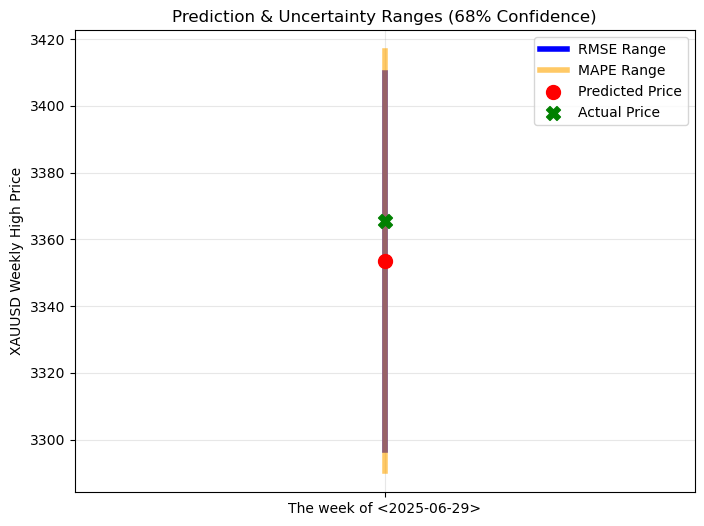

In [68]:
# Extract values from the ranges dictionary
rmse_lower = ranges['rmse_based']['lower']
rmse_upper = ranges['rmse_based']['upper']
mape_lower = ranges['mape_based']['lower']
mape_upper = ranges['mape_based']['upper']

# X-axis will just be a placeholder for the prediction point
x_pos = 0

plt.figure(figsize=(8, 6))

# --- RMSE-based range ---
plt.plot([x_pos, x_pos], [rmse_lower, rmse_upper], color='blue', linewidth=4, label='RMSE Range')

# --- MAPE-based range ---
plt.plot([x_pos, x_pos], [mape_lower, mape_upper], color='orange', linewidth=4, alpha=0.6, label='MAPE Range')

# --- Predicted price ---
plt.scatter(x_pos, predicted_price, color='red', s=100, zorder=3, label='Predicted Price')

# --- Actual price ---
plt.scatter(x_pos, actual_price, color='green', s=100, zorder=3, marker='X', label='Actual Price')

# Labels and legend
plt.xticks([x_pos], ['The week of <2025-06-29>'])
plt.ylabel('XAUUSD Weekly High Price')
plt.title(f"Prediction & Uncertainty Ranges ({ranges['confidence']*100:.0f}% Confidence)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
